<a href="https://colab.research.google.com/github/ehBeak/AcountApp/blob/main/finalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

!pip install sas7bdat

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/n

In [13]:
import sas7bdat
from sas7bdat import *
import plotly.express as px
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.core.array_algos.take import take_2d_multi

sns.set_style('dark')
plt.rc('font', family='NanumBarunGothic') 
plt.rcParams['axes.grid'] = True 

In [181]:
def filtering(survey):
  survey = survey[survey['age']>=19]
  survey = survey[survey['BD1']==2]

  survey = survey[['sex', 'age', 'HE_BMI', 'BD1_11', 'BD2_31', 'BD2_1', 'BD2_14']]
  survey.head()

  # 선택하여 열 이름 변경하기
  survey.rename(
      columns={'HE_BMI':'bmi', 
             'BD1_11':'drinking_frequency', 
             'BD2_31':'binge_drinking', 
             'BD2_1':'drinking_quantity', 
             'BD2_14':'drinking_quantity_10_over'}, inplace=True)
  

  # 음주 빈도
  survey['drinking_frequency'].replace(
      to_replace=[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 9.0], 
      value=[0, 0.1, 0.25, 1, 2, 4, None], inplace=True)

  # 폭음
  survey['binge_drinking'].replace(
      to_replace=[1.0, 2.0, 3.0, 4.0, 5.0, 8.0, 9.0], 
      value=[0, 0.1, 0.25, 1, 2, None, None], inplace=True)

  survey['drinking_quantity_10_over'].replace(
      to_replace=[888, 999], 
      value=[None, None], inplace=True)

  # 한번 마실 때 음주량
  survey['drinking_quantity'].replace(
      to_replace=[1.0, 2.0, 3.0, 4.0, 5.0, 8.0, 9.0], 
      value=[1, 3, 5, 7, 10, None, None], inplace=True)

  # 열 삭제
  survey = survey.drop(labels='drinking_quantity_10_over',axis=1)

  # 열 생성 1년간 total 알콜 섭취량 : 음주 빈도 * 음주량 == total_drinking_quantity
  survey['total_drinking_quantity'] = survey['drinking_frequency'] * survey['drinking_quantity']

  # bmi None인 데이터 없애기
  survey['bmi']=survey['bmi'].fillna(survey['bmi'].median())
  survey.dropna(inplace=True)

  survey.to_csv('drinking_bmi.csv')

  survey['total_drinking_quantity'] = survey['total_drinking_quantity'].astype(float)
  survey['drinking_frequency'] = survey['drinking_frequency'].astype(float)
  
  return survey



In [182]:
sas7bdat_file = SAS7BDAT("hn21_all.sas7bdat")
survey_21 = sas7bdat_file.to_data_frame()
survey_21 = filtering(survey_21)

In [183]:
sas7bdat_file = SAS7BDAT("hn20_all.sas7bdat")
survey_20 = sas7bdat_file.to_data_frame()
survey_20=filtering(survey_20)

In [184]:
sas7bdat_file = SAS7BDAT("hn19_all.sas7bdat")
survey_19 = sas7bdat_file.to_data_frame()
survey_19=filtering(survey_19)

<ipython-input-181-4d00791ab1d3>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  survey.rename(


In [185]:
survey=pd.concat([survey_21,survey_20, survey_19])
survey

,sex,age,bmi,drinking_frequency,binge_drinking,drinking_quantity,total_drinking_quantity
0,1.0,61.0,26.789017,2.00,1.00,7.0,14.00
1,1.0,57.0,25.506641,4.00,2.00,7.0,28.00
2,2.0,39.0,23.075711,4.00,2.00,10.0,40.00
3,2.0,19.0,21.911175,1.00,0.25,7.0,7.00
5,2.0,72.0,28.166306,0.00,0.00,3.0,0.00
...,...,...,...,...,...,...,...
8101,1.0,55.0,24.370606,2.00,0.25,7.0,14.00
8102,2.0,53.0,23.764537,0.25,0.00,1.0,0.25
8103,2.0,26.0,19.409690,1.00,0.25,7.0,7.00
8104,1.0,62.0,18.681380,1.00,1.00,5.0,5.00


In [224]:
survey['total_drinking_quantity'].value_counts()
# survey[survey['drinking_quantity']==10].cou


0.00     3205
10.00    1051
3.00      913
1.00      886
0.25      807
20.00     735
7.00      669
5.00      610
14.00     569
6.00      484
0.75      439
2.00      371
28.00     337
40.00     294
1.25      221
1.75      219
12.00     173
4.00      128
2.50      116
Name: total_drinking_quantity, dtype: int64

In [140]:
survey.isnull().sum() # 결측값 확인

sex                        0
age                        0
bmi                        0
drinking_frequency         0
binge_drinking             0
drinking_quantity          0
total_drinking_quantity    0
dtype: int64

In [141]:
survey #전체 음주량이 동일할 때, 나눠서 먹는게 좋아?(빈도 많이 소량씩), 그냥 한번에 다 먹는게 좋아? -> total_drinking_quantity를 1로 맞추기

,sex,age,bmi,drinking_frequency,binge_drinking,drinking_quantity,total_drinking_quantity
0,1.0,61.0,26.789017,130.0,52.0,7.0,910.0
1,1.0,57.0,25.506641,260.0,365.0,7.0,1820.0
2,2.0,39.0,23.075711,260.0,365.0,10.0,2600.0
3,2.0,19.0,21.911175,36.0,12.0,7.0,252.0
5,2.0,72.0,28.166306,6.0,6.0,3.0,18.0
...,...,...,...,...,...,...,...
8101,1.0,55.0,24.370606,130.0,12.0,7.0,910.0
8102,2.0,53.0,23.764537,12.0,0.0,1.0,12.0
8103,2.0,26.0,19.409690,36.0,12.0,7.0,252.0
8104,1.0,62.0,18.681380,36.0,52.0,5.0,180.0


In [142]:
print(survey['bmi'].corr(survey['drinking_frequency']))
print(survey['bmi'].corr(survey['binge_drinking']))
print(survey['bmi'].corr(survey['drinking_quantity']))
print(survey['bmi'].corr(survey['total_drinking_quantity']))
print(survey['bmi'].corr(survey['drinking_frequency']))

0.016850712311451573
0.05761433850991653
0.14346487591630944
0.07187343937580479


In [153]:
# survey['bmi'] = survey['bmi'].astype(int)
# survey['drinking_frequency'] = survey['drinking_frequency'].astype(int)
# survey['binge_drinking'] = survey['binge_drinking'].astype(int)
# survey['drinking_quantity'] = survey['drinking_quantity'].astype(int)

In [161]:
from sklearn.preprocessing import minmax_scale
test = survey
test['binge_drinking'] = minmax_scale(survey['binge_drinking'])
print(test)

      sex   age  bmi  drinking_frequency  binge_drinking  drinking_quantity  \
0     1.0  61.0   26                 130        0.142466                  7   
1     1.0  57.0   25                 260        1.000000                  7   
2     2.0  39.0   23                 260        1.000000                 10   
3     2.0  19.0   21                  36        0.032877                  7   
5     2.0  72.0   28                   6        0.016438                  3   
...   ...   ...  ...                 ...             ...                ...   
8101  1.0  55.0   24                 130        0.032877                  7   
8102  2.0  53.0   23                  12        0.000000                  1   
8103  2.0  26.0   19                  36        0.032877                  7   
8104  1.0  62.0   18                  36        0.142466                  5   
8105  2.0  48.0   20                  36        0.000000                  1   

      total_drinking_quantity  
0                  

In [204]:
survey

,sex,age,bmi,drinking_frequency,binge_drinking,drinking_quantity,total_drinking_quantity
0,1.0,61.0,26.789017,2.00,1.00,7.0,14.00
1,1.0,57.0,25.506641,4.00,2.00,7.0,28.00
2,2.0,39.0,23.075711,4.00,2.00,10.0,40.00
3,2.0,19.0,21.911175,1.00,0.25,7.0,7.00
5,2.0,72.0,28.166306,0.00,0.00,3.0,0.00
...,...,...,...,...,...,...,...
8101,1.0,55.0,24.370606,2.00,0.25,7.0,14.00
8102,2.0,53.0,23.764537,0.25,0.00,1.0,0.25
8103,2.0,26.0,19.409690,1.00,0.25,7.0,7.00
8104,1.0,62.0,18.681380,1.00,1.00,5.0,5.00


In [219]:
test = survey.drop(labels=['sex','age'], axis=1)
from statsmodels.formula.api import ols, glm
Rformula='bmi~drinking_frequency+total_drinking_quantity'
regression_result=ols(Rformula,data=test).fit()
regression_result.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    bmi   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     86.13
Date:                Sat, 10 Jun 2023   Prob (F-statistic):           7.17e-38
Time:                        22:27:52   Log-Likelihood:                -33162.
No. Observations:               12227   AIC:                         6.633e+04
Df Residuals:                   12224   BIC:                         6.635e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  24.1199      0.046    528.409      0.000      24.030      24.209
drinking_frequency         -0.4833      0.050     -9.616      0.000      -0.582      -0.385
total_drinking_quantity     0.0872      0.007     12.992      0.000       0.074       0.100
==============================================================================
Omnibus:                     1579.127   Durbin-Watson:                   1.880
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3306.505
Skew:                           0.796   Prob(JB):                         0.00
Kurtosis:                       4.989   Cond. No.                         18.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [223]:
#새로운 값
data={"drinking_frequency":[7],
"total_drinking_quantity":[40]}
sample=pd.DataFrame(data)
sample_predict=regression_result.predict(sample)
print(sample_predict)

0    24.224625
dtype: float64


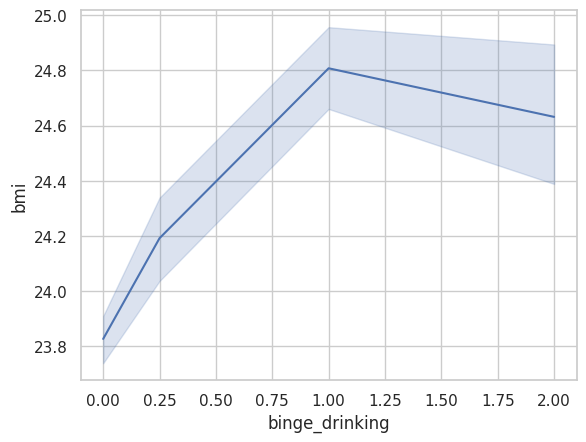

In [195]:
sns.lineplot(x='binge_drinking', y='bmi', data=survey, dashes=False, markers=True)
plt.show()

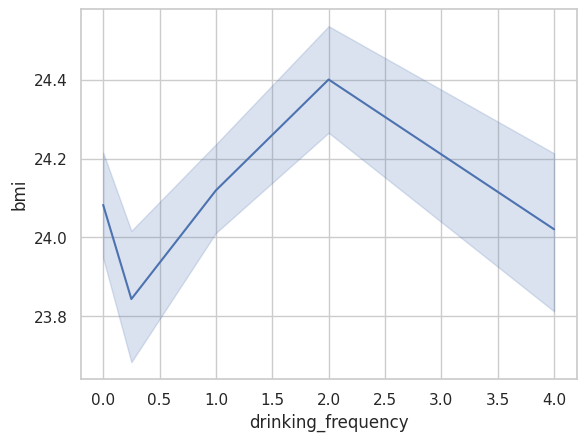

In [196]:
sns.lineplot(x='drinking_frequency', y='bmi', data=survey)
plt.show()

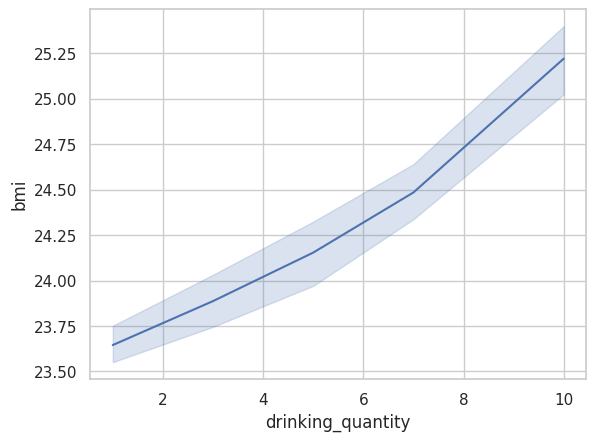

In [198]:
sns.lineplot(x='drinking_quantity', y='bmi', data=survey)
plt.show()

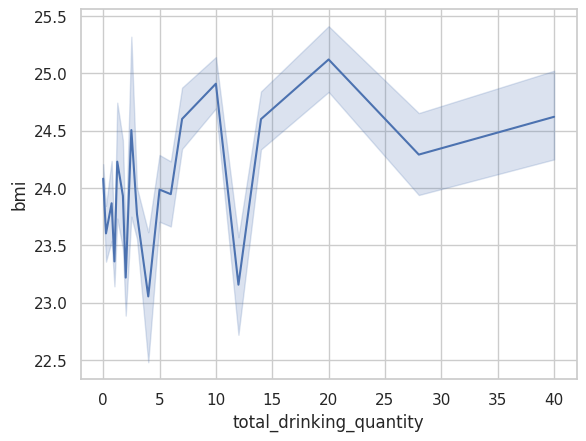

In [199]:
sns.lineplot(x='total_drinking_quantity', y='bmi', data=survey)
plt.show()

In [ ]:
sns.lineplot(x='binge_drinking', y='bmi', huedata=survey)
plt.show()

In [75]:
survey=survey[(survey['bmi'] > 25)]

In [123]:


test.loc[(test['bmi']<18.5), 'bmi']=1.0
test.loc[(test['bmi']>=18.5)&(test['bmi']<25.0), 'bmi']=2.0
test.loc[(test['bmi']>=25.0)&(test['bmi']<30.0), 'bmi']=3.0
test.loc[(test['bmi']>=30.0)&(test['bmi']<35.0), 'bmi']=4.0
test.loc[(test['bmi']>=35.0), 'bmi']=5.0


test

,sex,age,bmi,drinking_frequency,binge_drinking,drinking_quantity,total_drinking_quantity
0,1.0,61.0,3.0,130.0,52.0,8.0,1040.0
1,1.0,57.0,3.0,260.0,365.0,8.0,2080.0
2,2.0,39.0,2.0,260.0,365.0,10.0,2600.0
3,2.0,19.0,2.0,36.0,12.0,8.0,288.0
5,2.0,72.0,3.0,6.0,6.0,3.0,18.0
...,...,...,...,...,...,...,...
8101,1.0,55.0,2.0,130.0,12.0,8.0,1040.0
8102,2.0,53.0,2.0,12.0,0.0,1.0,12.0
8103,2.0,26.0,2.0,36.0,12.0,8.0,288.0
8104,1.0,62.0,2.0,36.0,52.0,5.0,180.0


In [132]:
import plotly.express as px

fig = px.scatter(survey_health_needs, x="bmi", y="tip", color='size', 
                 facet_row='smoker', facet_col='sex',
                #  category_orders=category_orders_dict,
                 width=800, height=800)
fig.show()

ValueError: ignored

In [93]:
test['drinking_quantity'].unique()

array([ 8.5, 14. ,  3.5,  1.5,  5.5, 11. , 12. , 10. , 15. , 21. , 18. ,
       16. , 20. , 13. , 35. , 17. , 28. , 25. , 24. , 30. ])

In [94]:

test.loc[(test['age']<29), 'age']=20
test.loc[(test['age']>=30)&(test['age']<40), 'age']=30
test.loc[(test['age']>=40)&(test['age']<50), 'age']=40
test.loc[(test['age']>=50)&(test['age']<60), 'age']=50
test.loc[(test['age']>=60)&(test['age']<70), 'age']=60
test.loc[(test['age']>=70)&(test['age']<80), 'age']=70
test.loc[(test['age']>=80), 'age']=80

In [13]:
test['total_drinking_quantity'].unique()

KeyError: ignored

In [18]:
df_freq

,1.0,2.0,3.0,4.0,5.0
20,10.740741,62.037037,20.370370,5.000000,1.851852
30,5.400372,55.121043,29.422719,8.007449,2.048417
40,2.550336,56.375839,33.020134,7.382550,0.671141
50,2.732240,61.065574,30.737705,4.644809,0.819672
60,1.700155,58.268934,34.157651,5.255023,0.618238
70,2.608696,60.579710,33.623188,3.188406,NaN
80,6.930693,66.336634,23.762376,2.970297,NaN


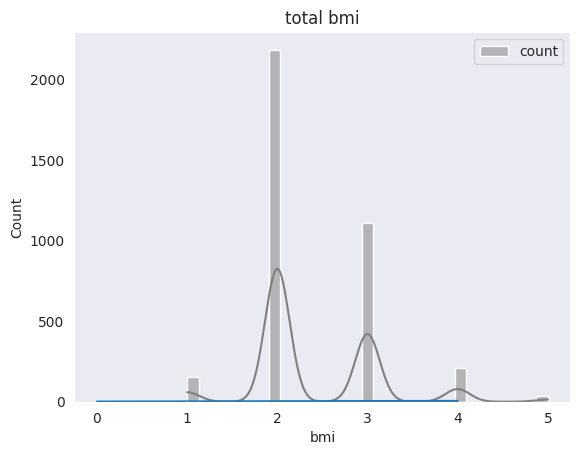

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('dark')
sns.histplot(test['bmi'], kde=True, color='grey', label='count')
# sns.histplot(test['quality'], kde=True, label='white wine')
plt.title("total bmi")
plt.legend()
plt.plot([1.0, 2.0, 3.0, 4.0, 5.0])
plt.show()

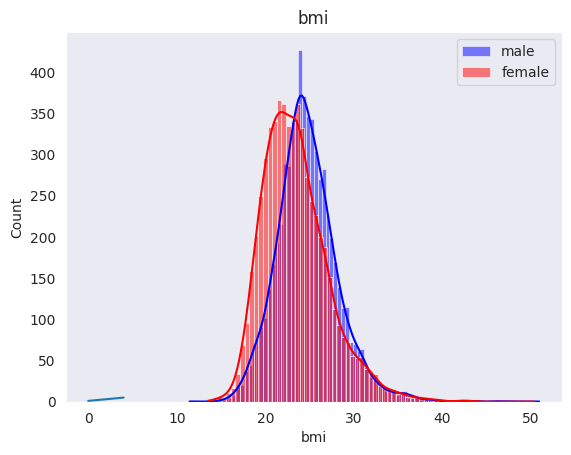

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('dark')
sns.histplot(survey[survey['sex']==1]['bmi'], kde=True, color='blue', label='male')
sns.histplot(survey[survey['sex']==2]['bmi'], kde=True, color='red', label='female')
plt.title("bmi")
plt.plot([1.0, 2.0, 3.0, 4.0, 5.0])
plt.legend()
plt.show()

In [136]:
import pandas as pd # 판다스 임포트.
import matplotlib.pyplot as plt # 맷플롯립 임포트.
import seaborn as sns # 시본 임포트

In [58]:
test2

,bmi,drinking_frequency,binge_drinking,drinking_quantity
0,3.0,4.0,3.0,8.5
1,3.0,5.0,4.0,8.5
2,2.0,5.0,4.0,14.0
3,2.0,3.0,2.0,8.5
5,3.0,1.0,1.0,3.5
...,...,...,...,...
7077,2.0,1.0,1.0,8.5
7078,2.0,1.0,0.0,1.5
7084,2.0,1.0,0.0,1.5
7086,4.0,4.0,3.0,8.5


In [97]:
test2=test.drop(labels=['sex','age'], axis=1)

<ipython-input-98-06e77b5b1d60>:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(df, dtype=np.bool)


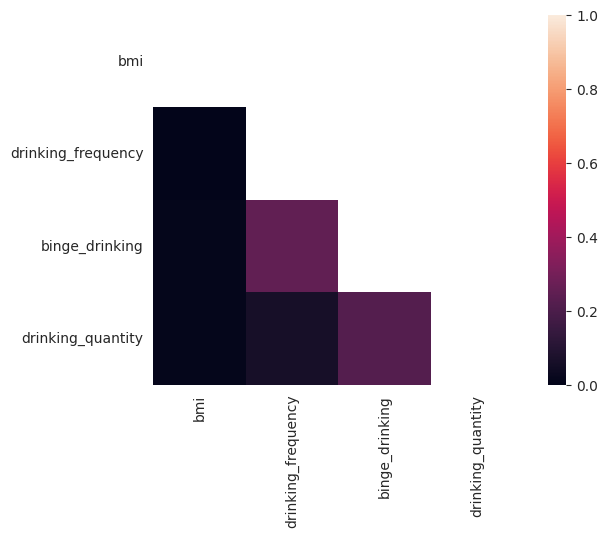

In [98]:
import seaborn as sns
import matplotlib.pyplot as plt



mask = np.zeros_like(df, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True




with sns.axes_style("white"):
  ax = sns.heatmap(df, mask=mask,vmin=0., vmax=1, square=True)

plt.show()

In [83]:
test2

,bmi,drinking_frequency,binge_drinking,drinking_quantity
0,3.0,4.0,3.0,4.0
1,3.0,5.0,4.0,4.0
2,2.0,5.0,4.0,5.0
3,2.0,3.0,2.0,4.0
5,3.0,1.0,1.0,2.0
...,...,...,...,...
7077,2.0,1.0,1.0,4.0
7078,2.0,1.0,0.0,1.0
7084,2.0,1.0,0.0,1.0
7086,4.0,4.0,3.0,4.0


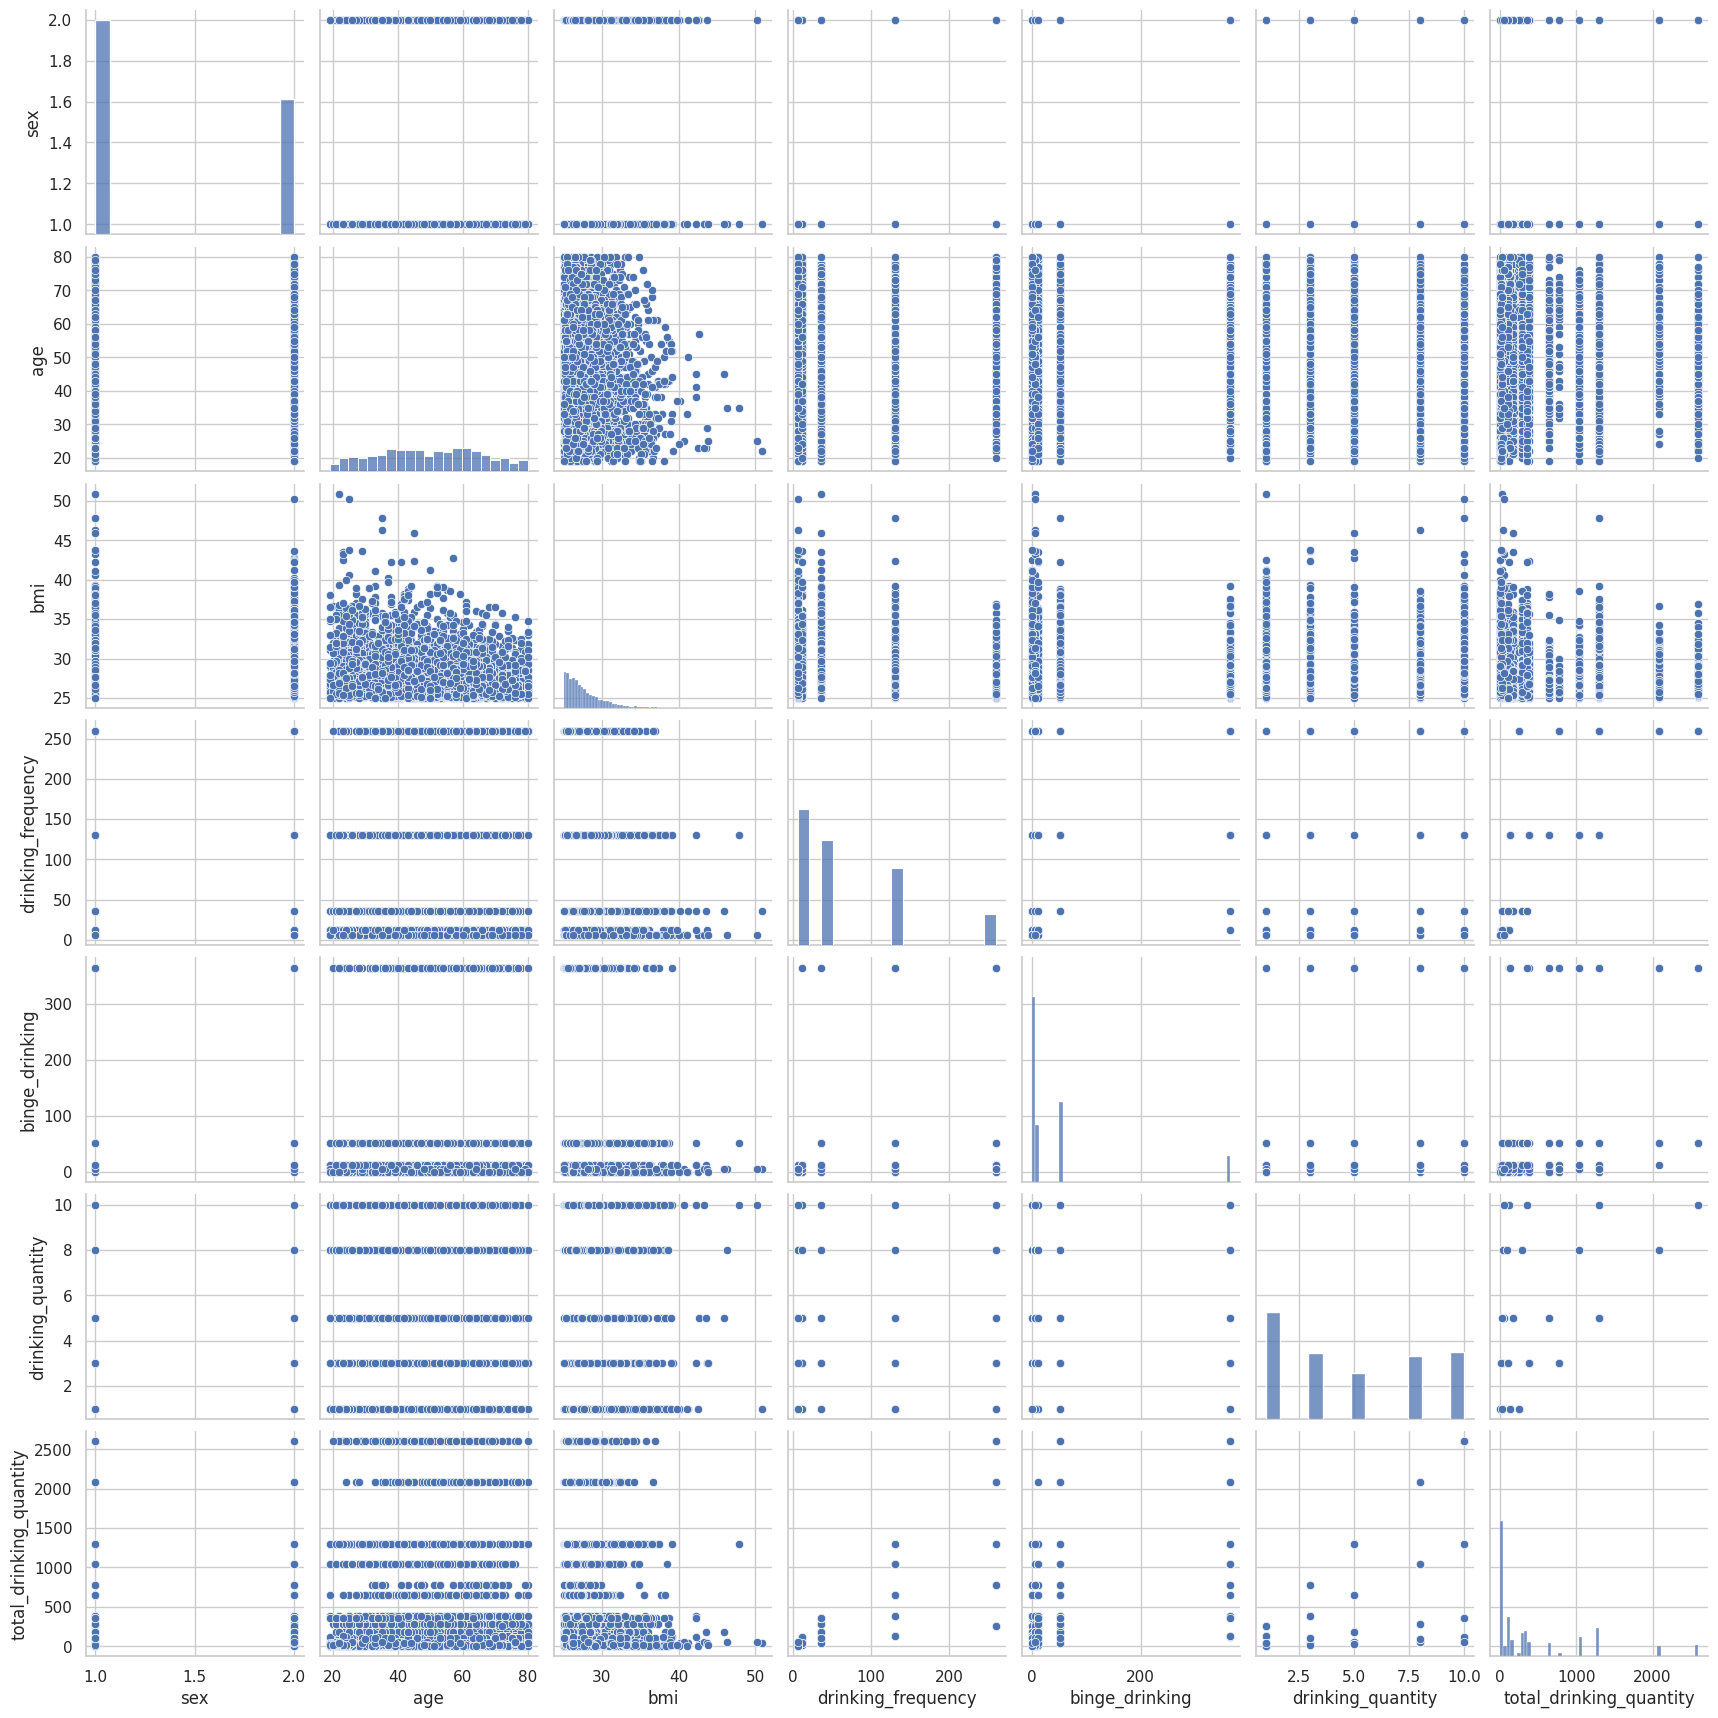

In [82]:
# whitegrid = 배경에 하얀 선을 넣는다.
sns.set(style='whitegrid')
sns.pairplot(survey)
plt.show()

eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1


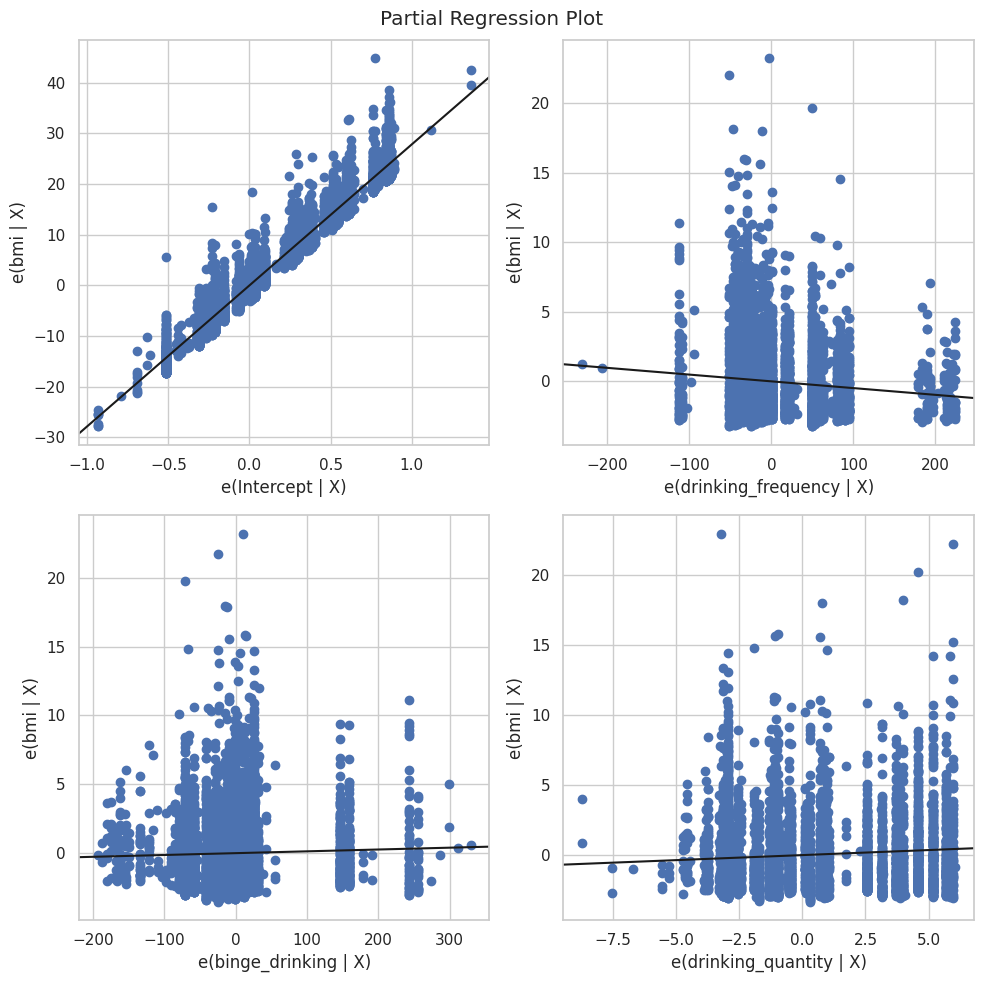

In [88]:
import statsmodels.api as sm
fig=plt.figure(figsize=(10,10))
sm.graphics.plot_partregress_grid(regression_result,fig=fig)
plt.show()

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 45208 (\N{HANGUL SYLLABLE NA}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 52404 (\N{HANGUL SYLLABLE CE}) missing from current font.
  func(*arg

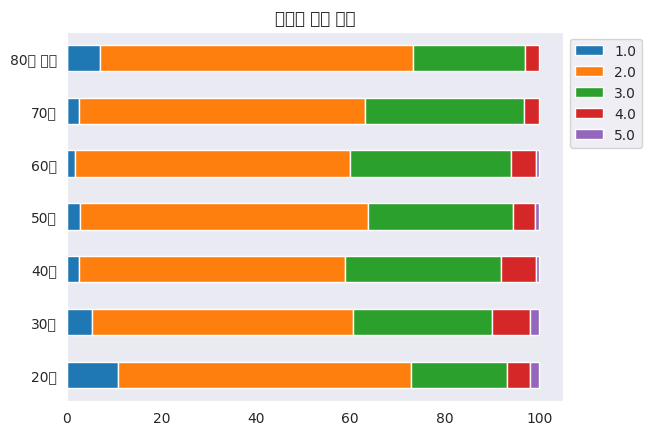

In [42]:
# 각 문항에 대한 응답 빈도 데이터

frequencies = {}       
for i in [20,30,40,50,60,70,80]:
    frequencies[i] = test[test['age']==i]['bmi'].value_counts()

# 행/열 전환
df_freq = pd.DataFrame(frequencies).T

# 빈도를 비율로 변환 (문항별)
df_freq = df_freq.div(df_freq.sum(axis=1), axis=0)*100

# columns 순서 정렬 (응답 1,2,3,4,5 순으로)
df_freq = df_freq.reindex(sorted(df_freq.columns), axis=1)

df_freq.index = ['20대','30대','40대','50대','60대','70대','80대 이상']
df_freq.plot(kind="barh", stacked=True)

plt.title('나이별 체중 비율')


plt.legend(bbox_to_anchor=(1,1))


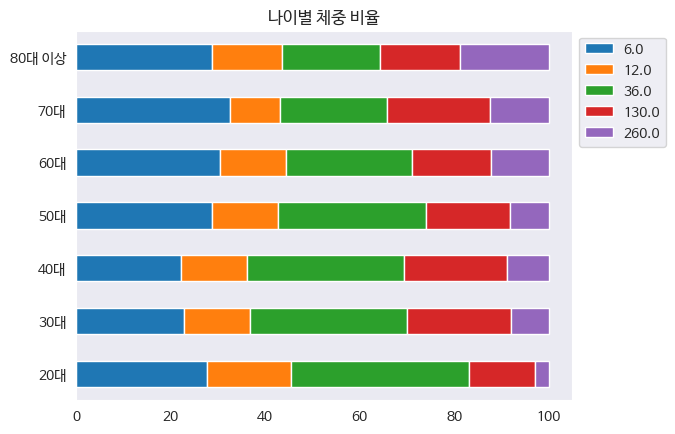

In [27]:
# 각 문항에 대한 응답 빈도 데이터

frequencies = {}       
for i in [20,30,40,50,60,70,80]:
    frequencies[i] = test[test['age']==i]['drinking_frequency'].value_counts()

# 행/열 전환
df_freq = pd.DataFrame(frequencies).T

# 빈도를 비율로 변환 (문항별)
df_freq = df_freq.div(df_freq.sum(axis=1), axis=0)*100

# columns 순서 정렬 (응답 1,2,3,4,5 순으로)
df_freq = df_freq.reindex(sorted(df_freq.columns), axis=1)

df_freq.index = ['20대','30대','40대','50대','60대','70대','80대 이상']
df_freq.plot(kind="barh", stacked=True)

plt.title('나이별 체중 비율')


plt.legend(bbox_to_anchor=(1,1))


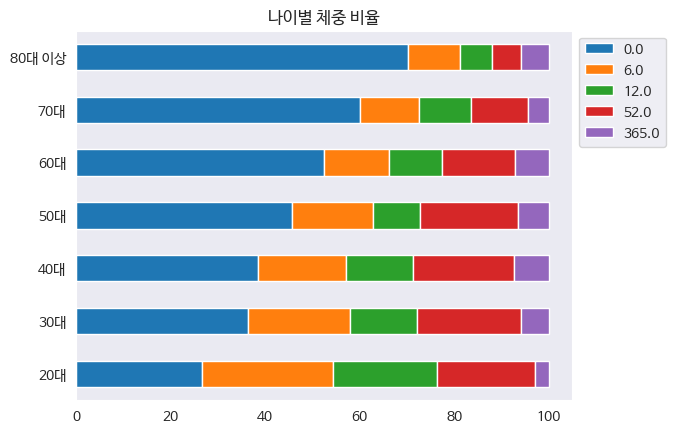

In [28]:
# 각 문항에 대한 응답 빈도 데이터

frequencies = {}       
for i in [20,30,40,50,60,70,80]:
    frequencies[i] = test[test['age']==i]['binge_drinking'].value_counts()

# 행/열 전환
df_freq = pd.DataFrame(frequencies).T

# 빈도를 비율로 변환 (문항별)
df_freq = df_freq.div(df_freq.sum(axis=1), axis=0)*100

# columns 순서 정렬 (응답 1,2,3,4,5 순으로)
df_freq = df_freq.reindex(sorted(df_freq.columns), axis=1)

df_freq.index = ['20대','30대','40대','50대','60대','70대','80대 이상']
df_freq.plot(kind="barh", stacked=True)

plt.title('나이별 체중 비율')


plt.legend(bbox_to_anchor=(1,1))


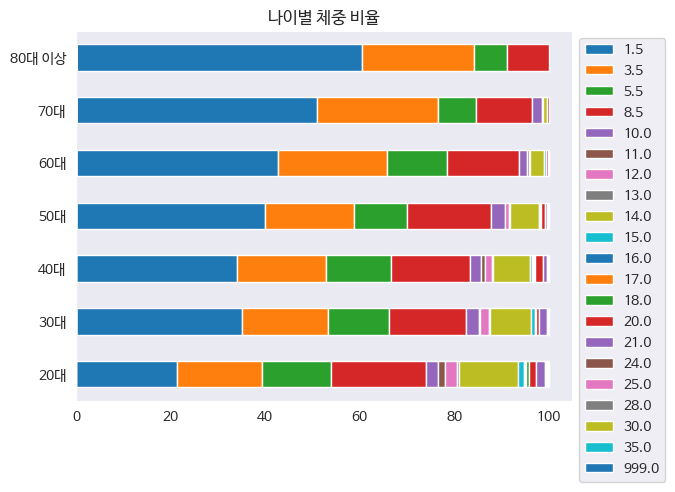

In [29]:
# 각 문항에 대한 응답 빈도 데이터

frequencies = {}       
for i in [20,30,40,50,60,70,80]:
    frequencies[i] = test[test['age']==i]['drinking_quantity'].value_counts()

# 행/열 전환
df_freq = pd.DataFrame(frequencies).T

# 빈도를 비율로 변환 (문항별)
df_freq = df_freq.div(df_freq.sum(axis=1), axis=0)*100

# columns 순서 정렬 (응답 1,2,3,4,5 순으로)
df_freq = df_freq.reindex(sorted(df_freq.columns), axis=1)

df_freq.index = ['20대','30대','40대','50대','60대','70대','80대 이상']
df_freq.plot(kind="barh", stacked=True)

plt.title('나이별 체중 비율')


plt.legend(bbox_to_anchor=(1,1))


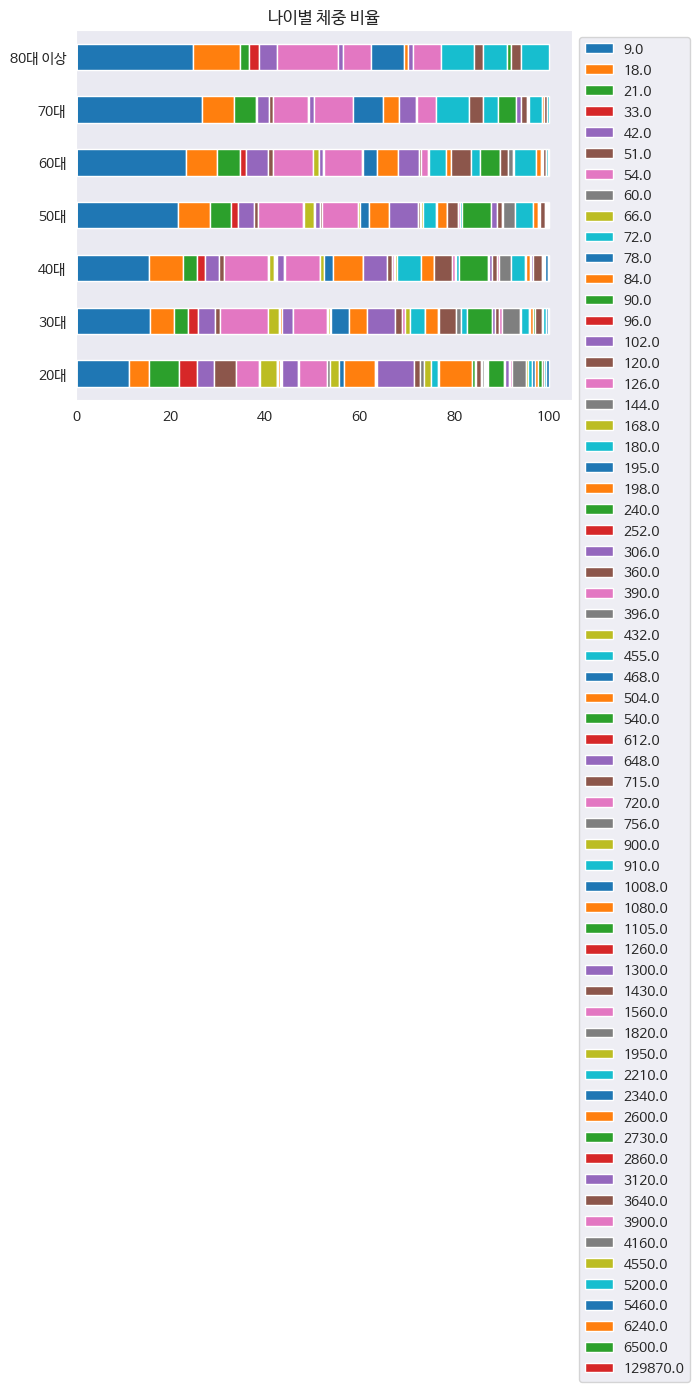

In [30]:
# 각 문항에 대한 응답 빈도 데이터

frequencies = {}       
for i in [20,30,40,50,60,70,80]:
    frequencies[i] = test[test['age']==i]['total_drinking_quantity'].value_counts()

# 행/열 전환
df_freq = pd.DataFrame(frequencies).T

# 빈도를 비율로 변환 (문항별)
df_freq = df_freq.div(df_freq.sum(axis=1), axis=0)*100

# columns 순서 정렬 (응답 1,2,3,4,5 순으로)
df_freq = df_freq.reindex(sorted(df_freq.columns), axis=1)

df_freq.index = ['20대','30대','40대','50대','60대','70대','80대 이상']
df_freq.plot(kind="barh", stacked=True)

plt.title('나이별 체중 비율')


plt.legend(bbox_to_anchor=(1,1))


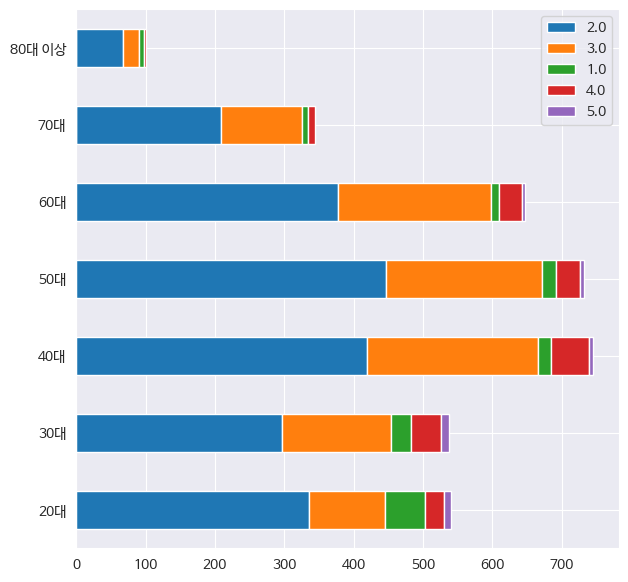

In [127]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('dark')
plt.rc('font', family='NanumBarunGothic') 
plt.rcParams['axes.grid'] = True 

def bar_chart(feature):
    age_20 = test[test['age']==20][feature].value_counts()
    age_30 = test[test['age']==30][feature].value_counts()
    age_40 = test[test['age']==40][feature].value_counts()
    age_50 = test[test['age']==50][feature].value_counts()
    age_60 = test[test['age']==60][feature].value_counts()
    age_70 = test[test['age']==70][feature].value_counts()
    age_80 = test[test['age']==80][feature].value_counts()
    df = pd.DataFrame([age_20,age_30,age_40,age_50,age_60,age_70,age_80])
    df.index = ['20대','30대','40대','50대','60대','70대','80대 이상']
    df.plot(kind='barh',stacked=True)

bar_chart('bmi')

# age_20 = test[test['age']==20]['bmi'].value_counts().plot.pie(explode=[0,0.1], autopct='%1.1f%%', shadow=True)

In [29]:
!pip install statsmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [41]:
test

,sex,age,bmi,drinking_frequency,binge_drinking,drinking_quantity,total_drinking_quantity
0,1.0,61.0,3.0,130.0,52.0,8.5,1105.0
1,1.0,57.0,3.0,260.0,365.0,8.5,2210.0
2,2.0,39.0,2.0,260.0,365.0,14.0,3640.0
3,2.0,19.0,2.0,36.0,12.0,8.5,306.0
5,2.0,72.0,3.0,6.0,6.0,3.5,21.0
...,...,...,...,...,...,...,...
7077,1.0,43.0,2.0,6.0,6.0,8.5,51.0
7078,2.0,38.0,2.0,6.0,0.0,1.5,9.0
7084,2.0,54.0,2.0,6.0,0.0,1.5,9.0
7086,1.0,45.0,4.0,130.0,52.0,8.5,1105.0


In [74]:
# 회귀분석
'''
종속 변수(y)와 독립 변수(x1~x10) 구성
▪ 종속 변수(y): bmi
▪ 독립 변수(x1~x10): drinking_frequency, binge_drinking, drinking_quantity, total_drinking_quantity
▪ 독립 변수는 연속된 값을 가진 변수만 사용 가능
▪ ‘종속 변수~독립 변수 1+독립 변수 2+ ….. +독립 변수 n’: 다중 회귀 분석
'''


from statsmodels.formula.api import ols, glm
Rformula='bmi~drinking_frequency+binge_drinking+drinking_quantity'
regression_result=ols(Rformula,data=test).fit()
regression_result.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1752: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    bmi   R-squared:                        -inf
Model:                            OLS   Adj. R-squared:                   -inf
Method:                 Least Squares   F-statistic:                    -1231.
Date:                Sat, 10 Jun 2023   Prob (F-statistic):               1.00
Time:                        19:02:57   Log-Likelihood:             1.2006e+05
No. Observations:                3698   AIC:                        -2.401e+05
Df Residuals:                    3694   BIC:                        -2.401e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              1.0000   5.36e-17   1.87e+16      0.000       1.000       1.000
drinking_frequency  4.146e-19   5.76e-19      0.720      0.471   -7.14e-19    1.54e-18
binge_drinking     -1.824e-18   5.44e-19     -3.352      0.001   -2.89e-18   -7.57e-19
drinking_quantity   2.617e-17   7.91e-18      3.309      0.001    1.07e-17    4.17e-17
==============================================================================
Omnibus:                      346.495   Durbin-Watson:                   0.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1854.732
Skew:                           0.278   Prob(JB):                         0.00
Kurtosis:                       6.425   Cond. No.                         212.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1


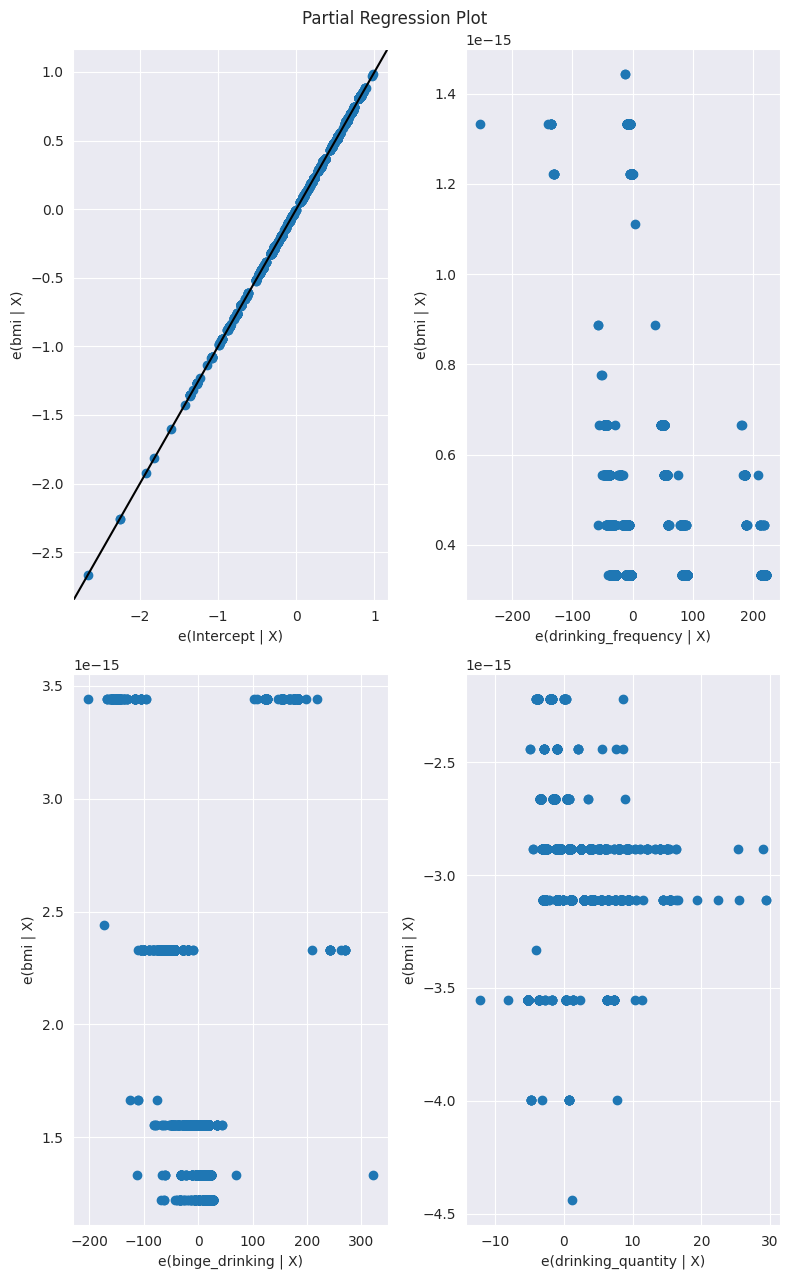

In [75]:
import statsmodels.api as sm
fig=plt.figure(figsize=(8,13))
sm.graphics.plot_partregress_grid(regression_result,fig=fig)
plt.show()

In [ ]:
# 성별에 따른 비만도 확인
# 연령대에 따른 비만도 확인
# 빈도에 따른 비만도 확인
# 폭음에 따른 비만도 확인
# 전체 음주량에 따른 비만도 확인

AttributeError: ignored

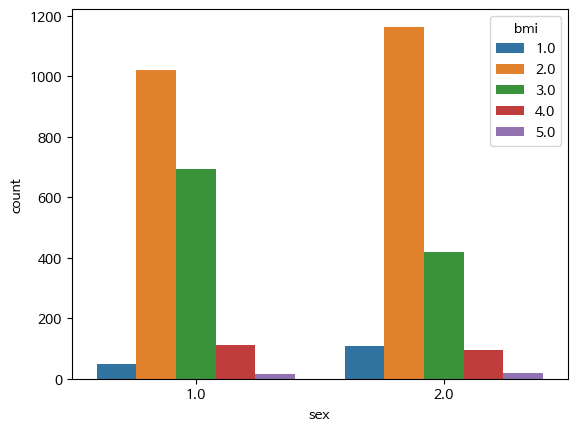

In [16]:
# 성별에 따른 비만도 확인
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic') 
sns.countplot(x='sex',hue='bmi',data=survey_health_needs)
plt.index(['남', '여'])
plt.title('male vs female')
plt.show()

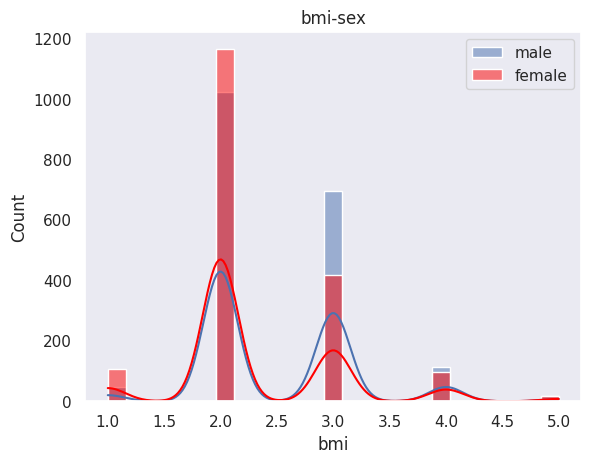

In [251]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('dark')

sns.histplot(test[test['sex'] == 1]['bmi'], kde=True, label='male')
sns.histplot(test[test['sex'] == 2]['bmi'], kde=True, color='red', label='female')
plt.title("bmi-sex")
plt.legend()
plt.show()

<Axes: >

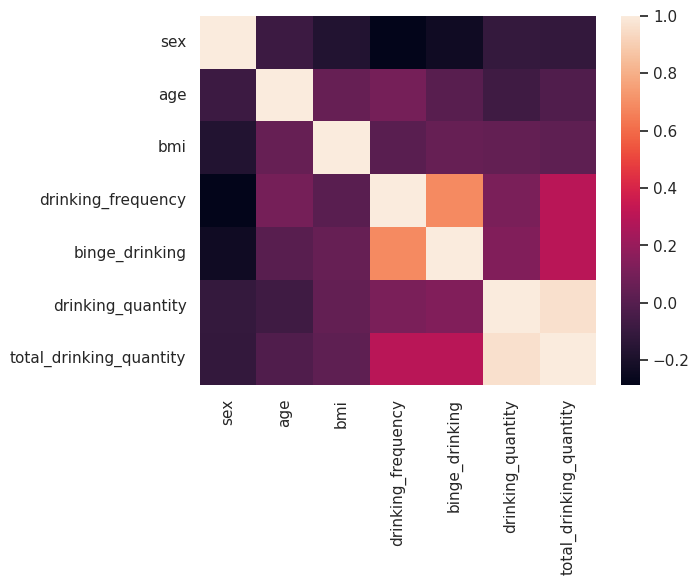

In [198]:
sns.set_style('dark')

sns.histplot(survey_health_needs[survey_health_needs['sex'] == 1]['bmi'], kde=True, label='male')
sns.histplot(survey_health_needs[survey_health_needs['sex'] == 2]['bmi'], kde=True, color='red', label='female')
plt.title("bmi-sex")
plt.legend()
plt.show()

<Figure size 3000x800 with 0 Axes>

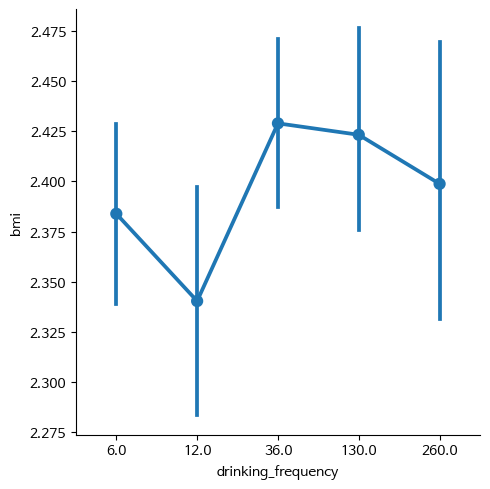

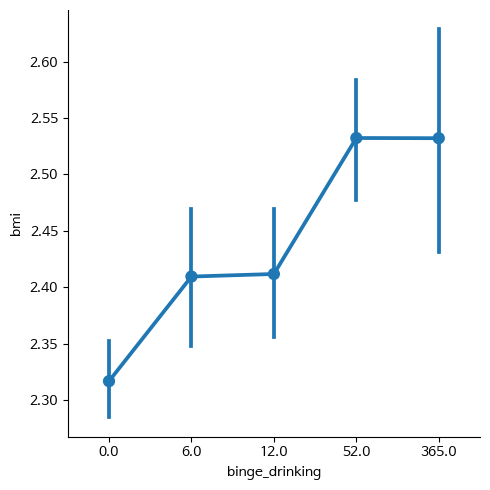

In [15]:
# bmi_drinking_frequency # 빈도
# bmi_binge_drinking # 폭음
# bmi_drinking_quantity # 하루에 먹는 량
# bmi_total_drinking_quantity # 전체 량
plt.figure(figsize = (30,8))

sns.catplot(x='drinking_frequency', y='bmi', data=test, kind='point')
plt.show()

sns.catplot(x='binge_drinking', y='bmi', data=test, kind='point')
plt.show()

In [ ]:


sns.catplot(x='drinking_quantity', y='bmi', data=test, kind='point')
plt.show()

sns.catplot(x='total_drinking_quantity', y='bmi', data=test, kind='point')
plt.show()
